<a href="https://colab.research.google.com/github/fabio-weydson/sandbox-datascience/blob/main/CE_1_2_por_Analise%20LDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Estudo de caso 1.2: Análise de LDA (*Alocação Latente de Dirichlet*)

Bibliotecas para importar:

In [ ]:
import sys, re, time, string, random, csv, argparse
import requests
import numpy as n
import pandas as pd
import matplotlib.pyplot as plt

from scipy.special import psi

#Bibliotecas de web scraping
from bs4 import BeautifulSoup

from tqdm.notebook import tqdm

#Bibliotecas de NLP
import nltk
nltk.download('punkt')
nltk.download('stopwords')
from nltk.tokenize import wordpunct_tokenize


print('\nBibliotecas importadas com sucesso!')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.

Bibliotecas importadas com sucesso!


# Geração do banco de dados (*Web Scraping*)

Primeiramente, precisamos obter a lista de professores do departamento de EECS e o laboratório ao qual pertencem. Para isso, podemos usar bibliotecas de _Web scraping_ como `BeautifulSoup`. Este tipo de biblioteca oferece funções para explorar o código fonte de páginas web e obter informações de seu conteúdo. 

In [ ]:
#Url da lista de professores do EECS
url_eecs_fac = 'https://www.eecs.mit.edu/people/faculty-advisors'
#Baixando o código fonte da url referida
html_data = requests.get(url_eecs_fac).text
soup = BeautifulSoup(html_data, 'html.parser')
#Salvando o nome e o laboratório em duas listas
fac = [el.text for el in soup.find_all(class_ = 'field-content card-title')]
labs = []
for lab_raw in soup.find_all(class_ = 'views-field views-field-term-node-tid'):
    try:
        labs.append(lab_raw.find('a').text)
    except:
        labs.append('')
#Unindo as duas listas e eliminando os professores que não pertencem a CSAIL, MTL, RLE ou LIDS
fac_dept = list(zip(fac,labs))
fac_dept = [tup for tup in fac_dept if tup[1] in set(['CSAIL','MTL','RLE','LIDS'])]

print('Número de professores de EECS: {}'.format(len(fac_dept)))
print(fac_dept[:5],'...')

Definimos uma função para obter todos os artigos de _arXiv_ de um determinado autor.

In [ ]:
def get_articles_for_author(author):
    base_url = 'https://arxiv.org/search/?query=%22{name}%22&searchtype=author&abstracts=show&order=-announced_date_first&size=200'
    author_query_url = base_url.format(name= author.replace(' ','+'))
    query_result = requests.get(author_query_url).text
    soup = BeautifulSoup(query_result, 'html.parser')
    articles = soup.find_all(class_ = 'arxiv-result')

    ids = [el.find(class_ = 'list-title is-inline-block').find('a').text.strip('arXiv:') for el in articles]
    ids = [el.split('/')[1] if el.find('/')>=0 else el for el in ids]
    
    titles = [el.find(class_ = 'title is-5 mathjax').text.strip(' \n') for el in articles]
    authors = [[author.text for author in el.find(class_ = 'authors').find_all('a')] for el in articles]
    abstracts = []
    for el in articles:   
        try:
            abstracts.append(el.find(class_ = 'abstract-full has-text-grey-dark mathjax').text[9:-16])
        except:
            abstracts.append(el.find(class_ = 'abstract-short has-text-grey-dark mathjax').text[9:-16])
    urls = [el.find(class_ = 'list-title is-inline-block').find('a')['href'] for el in articles]
    
    return ids, titles, authors, urls, abstracts

author = fac_dept[23][0]
print('Exemplo de um artigo de {}: \n'.format(author))
ids, titles, authors, urls, abstracts = get_articles_for_author(author)
i = 0
print('arXiv ID: {} (url: {} )'.format(ids[i],urls[i]))
print('Título: {}'.format(titles[i]))
print('Autores: {}'.format(authors[i]))
print('---\n{}\n---'.format(abstracts[i]))

Uma vez que temos a função definida e comprovamos que ela funciona, podemos iterar a lista de professores para obter os artigos de cada professor.

In [ ]:
ids = []
titles = []
authors = []
labs = []
EECS_facs = []
urls = []
abstracts = []
print('Baixando artigos de cada professor:')
t0 = time.time()
for i,fac in enumerate(fac_dept):
    id_list, title_list, author_list, url_list, abstract_list  = get_articles_for_author(fac[0])
    ids += id_list
    titles += title_list
    authors += author_list
    urls += url_list
    abstracts += abstract_list
    labs += [fac[1]]*len(id_list)
    EECS_facs += [fac[0]]*len(id_list)
    if round(i/10) == i/10:
        print('{}/{} autores'.format(i,len(fac_dept)))
tf = time.time()
print('{} artigos baixados em {:.2f}s'.format(len(ids),tf-t0))

Podemos salvar toda a informação em uma tabela de `pandas`. A célula a seguir mostra como fazer isso:

In [ ]:
df = pd.DataFrame({'id':ids,'title':titles,'EECS_prof':EECS_facs,'lab':labs,'authors':authors,'url':urls,'abstract':abstracts})
df[['id','lab']] = df[['id','lab']].drop_duplicates()
df.head()

## Obtenção do vocabulário 

Para poder utilizar as funções disponibilizadas no roteiro do estudo de caso, é necessário um arquivo de vocabulário no formato `.csv`. Podemos obtê-lo a partir do repositório do estudo original de LDA SVI:

In [ ]:
url = 'https://raw.githubusercontent.com/blei-lab/onlineldavb/master/dictnostops.txt'
vocab_list = pd.Series(requests.get(url).text.split('\n')[:-1])
vocab = {}
for index, word in enumerate(vocab_list):
    vocab[word] = index
vocab_list

# LDA-SVI


## Funções auxiliares

### Geração de atributos de cada texto (recontagem de palavras)

In [ ]:
def parseDocument(doc, vocab):
    wordslist = list()
    countslist = list()
    doc = doc.lower()
    tokens = wordpunct_tokenize(doc)
    
    dictionary = dict()
    for word in tokens:
        if word in vocab:
            wordtk = vocab[word]
            if wordtk not in dictionary:
                dictionary[wordtk] = 1
            else:
                dictionary[wordtk] += 1

    wordslist.append(list(dictionary.keys()))
    countslist.append(list(dictionary.values()))
    return (wordslist[0], countslist[0])

### Cálculo de distribuições de probabilidade

In [ ]:
def dirichlet_expectation(alpha):
    '''
    For a vector theta ~ Dir(alpha), computes E[log(theta)] given alpha.
    
    Taken from https://github.com/blei-lab/onlineldavb/blob/master/onlineldavb.py
    '''
    if (len(alpha.shape) == 1):
        return (psi(alpha) - psi(n.sum(alpha)))
    return (psi(alpha) - psi(n.sum(alpha, 1))[:, n.newaxis])

def beta_expectation(a, b, k):
    mysum = psi(a + b)
    Elog_a = psi(a) - mysum
    Elog_b = psi(b) - mysum
    Elog_beta = n.zeros(k)
    Elog_beta[0] = Elog_a[0]
    # print Elog_beta
    for i in range(1, k):
        Elog_beta[i] = Elog_a[i] + n.sum(Elog_b[0:i])
        # print Elog_beta
    # print Elog_beta
    return Elog_beta

def plottrace(x, Y, K, n, perp):
    for i in range(K):
        plt.plot(x, Y[i], label = "Topic %i" %(i+1))

    plt.xlabel("Number of Iterations")
    plt.ylabel("Probability of Each topic")
    plt.legend()
    plt.title("Trace plot for topic probabilities")
    plt.savefig("temp/plot_%i_%i_%f.png" %(K, n, perp))

## Implementação da LDA através da SVI

Obtemos a implementação da LDA através da SVI das fontes mencionadas no roteiro:
* https://github.com/qlai/stochasticLDA
* https://github.com/blei-lab/onlineldavb

In [ ]:
n.random.seed(10000001)
meanchangethresh = 1e-3
MAXITER = 10000

class SVILDA():
    """
        Arguments:
        K: Number of topics
        vocab: A set of words to recognize. When analyzing documents, any word
           not in this set will be ignored.
        D: Total number of documents in the population. For a fixed corpus,
           this is the size of the corpus. In the truly online setting, this
           can be an estimate of the maximum number of documents that
           could ever be seen.
        alpha: Hyperparameter for prior on weight vectors theta
        eta: Hyperparameter for prior on topics beta
        tau: A (positive) learning parameter that downweights early iterations
        kappa: Learning rate: exponential decay rate---should be between
             (0.5, 1.0] to guarantee asymptotic convergence.
        Note that if you pass the same set of D documents in every time and
        set kappa=0 this class can also be used to do batch VB.
    """
        
    def __init__(self, vocab, K, D, alpha, eta, tau, kappa, docs, iterations, parsed = False):
        self._vocab = vocab
        self._V = len(vocab)
        self._K = K
        self._D = D
        self._alpha = alpha
        self._eta = eta
        self._tau = tau
        self._kappa = kappa
        self._lambda = 1* n.random.gamma(100., 1./100., (self._K, self._V))
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)
        self._docs = docs
        self.ct = 0
        self._iterations = iterations
        self._parsed = parsed
        self._trace_lambda = {}
        for i in range(self._K):
            self._trace_lambda[i] = [self.computeProbabilities()[i]]
        self._x = [0]

    def updateLocal(self, doc): #word_dn is an indicator variable with dimension V
        (words, counts) = doc
        newdoc = []
        N_d = sum(counts)
        phi_d = n.zeros((self._K, N_d))
        gamma_d = n.random.gamma(100., 1./100., (self._K))
        Elogtheta_d = dirichlet_expectation(gamma_d)
        expElogtheta_d = n.exp(Elogtheta_d)
        for i, item in enumerate(counts):
            for j in range(item):
                newdoc.append(words[i])
        assert len(newdoc) == N_d, "error"

        for i in range(self._iterations):
            for m, word in enumerate(newdoc):
                phi_d[:, m] = n.multiply(expElogtheta_d, self._expElogbeta[:, word]) + 1e-100
                phi_d[:, m] = phi_d[:, m]/n.sum(phi_d[:, m])

            gamma_new = self._alpha + n.sum(phi_d, axis = 1)
            meanchange = n.mean(abs(gamma_d - gamma_new))
            if (meanchange < meanchangethresh):
                break

            gamma_d = gamma_new
            Elogtheta_d = dirichlet_expectation(gamma_d)
            expElogtheta_d = n.exp(Elogtheta_d)

        newdoc = n.asarray(newdoc)
        return phi_d, newdoc, gamma_d

    def updateGlobal(self, phi_d, doc):

        lambda_d = n.zeros((self._K, self._V))

        for k in range(self._K):
            phi_dk = n.zeros(self._V)
            for m, word in enumerate(doc):
                phi_dk[word] += phi_d[k][m] 
            lambda_d[k] = self._eta + self._D * phi_dk
        rho = (self.ct + self._tau) **(-self._kappa)
        self._lambda = (1-rho) * self._lambda + rho * lambda_d
        self._Elogbeta = dirichlet_expectation(self._lambda)
        self._expElogbeta = n.exp(self._Elogbeta)

        if self.ct % 10 == 9:
            for i in range(self._K):
                self._trace_lambda[i].append(self.computeProbabilities()[i])
            self._x.append(self.ct)

    def runSVI(self):
        for i in tqdm(range(self._iterations)):
            randint = random.randint(0, self._D-1)
            if self._parsed == False:
                doc = parseDocument(self._docs[randint],self._vocab)
            phi_doc, newdoc, gamma_d = self.updateLocal(doc)
            self.updateGlobal(phi_doc, newdoc)
            self.ct += 1
                
    def computeProbabilities(self):
        prob_topics = n.sum(self._lambda, axis = 1)
        prob_topics = prob_topics/n.sum(prob_topics)
        return prob_topics

    def getTopics(self, docs = None):
        prob_topics = self.computeProbabilities()
        prob_words = n.sum(self._lambda, axis = 0)

        if docs == None:
            docs = self._docs
        results = n.zeros((len(docs), self._K))
        for i, doc in enumerate(docs):
            parseddoc = parseDocument(doc, self._vocab)

            for j in range(self._K):
                aux = [self._lambda[j][word]/prob_words[word] for word in parseddoc[0]]
                doc_probability = [n.log(aux[k]) * parseddoc[1][k] for k in range(len(aux))]
                results[i][j] = sum(doc_probability) + n.log(prob_topics[j])
        finalresults = n.zeros(len(docs))
        for k in range(len(docs)):
            finalresults[k] = n.argmax(results[k])
        return finalresults, prob_topics

    def calcPerplexity(self, docs = None):
        perplexity = 0.
        doclen = 0.
        if docs == None:
            docs =  self._docs
        for doc in docs:
            parseddoc = parseDocument(doc, self._vocab)
            _, newdoc, gamma_d = self.updateLocal(parseddoc)
            approx_mixture = n.dot(gamma_d, self._lambda)
            # print(n.shape(approx_mixture))
            approx_mixture = approx_mixture / n.sum(approx_mixture)
            log_doc_prob = 0.
            for word in newdoc:
                log_doc_prob += n.log(approx_mixture[word])
            perplexity += log_doc_prob
            doclen += len(newdoc)
            # print(perplexity, doclen)
        perplexity = n.exp( - perplexity / doclen)
        print(perplexity)
        return perplexity

    def plotTopics(self, perp):
        plottrace(self._x, self._trace_lambda, self._K, self._iterations, perp)

def test(k, iterations):

    docs = getalldocs("alldocs2.txt")
    vocab = getVocab("dictionary2.csv")
    
    testset = SVILDA(vocab = vocab, K = k, D = len(docs), alpha = 0.2,
                     eta = 0.2, tau = 1024, kappa = 0.7, docs = docs,
                     iterations= iterations)
    testset.runSVI()
    finallambda = testset._lambda

    heldoutdocs = getalldocs("testdocs.txt")
    perplexity = testset.calcPerplexity(docs = heldoutdocs)

    with open("temp/%i_%i_%f_results.csv" %(k, iterations, perplexity), "w+") as f:
        writer = csv.writer(f)
        for i in range(k):
            bestwords = sorted(range(len(finallambda[i])), key=lambda j:finallambda[i, j])
            bestwords.reverse()
            writer.writerow([i])
            for j, word in enumerate(bestwords):
                writer.writerow([word, vocab.keys()[vocab.values().index(word)]])
                if j >= 15:
                    break
    topics, topic_probs = testset.getTopics()
    testset.plotTopics(perplexity)

    for kk in range(0, len(finallambda)):
        lambdak = list(finallambda[kk, :])
        lambdak = lambdak / sum(lambdak)
        temp = zip(lambdak, range(0, len(lambdak)))
        temp = sorted(temp, key = lambda x: x[0], reverse=True)
        # print temp
        print('topic %d:' % (kk))
        # feel free to change the "53" here to whatever fits your screen nicely.
        for i in range(0, 10):
            print('%20s  \t---\t  %.4f' % (vocab.keys()[vocab.values().index(temp[i][1])], temp[i][0]))

    with open("temp/%i_%i_%f_raw.txt" %(k, iterations, perplexity), "w+") as f:
        # f.write(finallambda)
        for result in topics:
            f.write(str(result) + " \n")
        f.write(str(topic_probs) + " \n")

# Resultados

Uma vez definidas todas as funções necessárias, só falta executar a análise de LDA:

(esta análise levará uns 25 minutos... seja paciente!)

In [ ]:
mode = 'normal'
K = 5
alpha = 0.2
eta = 0.2
tau = 1024
kappa = 0.7
iterations = 100000

if mode == "test":
    test(K, iterations)
if mode == "normal":
    docs = df.abstract.to_list()
    D = len(docs)
    print('number of docs: {}'.format(D))
    lda = SVILDA(vocab = vocab, K = K, D = D, alpha = alpha, 
                 eta = eta, tau = tau, kappa = kappa, docs = docs, 
                 iterations = iterations)
    lda.runSVI()
    lda

number of docs: 3215


Podemos observar a distribuição de probabilidades de cada palavra do vocabulário com respeito a cada tema identificado nos textos:

In [ ]:
lambda_df = pd.DataFrame({'word':list(vocab.keys())})
for i in range(K):
    lambda_df['Topic {}'.format(i+1)] = lda._lambda[i,:]
lambda_df

,word,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5
0,writings,0.200000,0.200000,0.200000,0.200000,0.200000
1,yellow,0.205041,2.561710,0.200012,0.205053,0.200681
2,four,0.206024,0.206503,0.206784,67.922909,0.218093
3,woods,0.200000,0.200000,0.200000,0.200000,0.200000
4,hanging,0.200006,2.286337,0.200011,0.202256,0.200003
...,...,...,...,...,...,...
7697,upwards,0.200865,0.209805,0.227811,0.202752,2.228676
7698,ranks,0.214025,0.200305,0.201769,7.905509,0.205591
7699,indirectly,0.206847,0.200437,0.200013,3.893451,0.200879
7700,volumes,0.200935,9.548821,0.202515,0.206820,0.206843


Para entender como o algoritmo de LDA calculou a distribuição de probabilidades de cada tema, podemos observar as 10 palabras com maior probabilidade por tema:

In [ ]:
finalresults, prob_topics = lda.getTopics()

for column,prob in list(zip(lambda_df.columns[1:],prob_topics)):
    print('{} probability: {:.2f}%'.format(column,prob*100))
    print(lambda_df.nlargest(10, [column])[['word',column]],'\n')

Topic 1 probability: 6.36%
          word     Topic 1
4583   channel  486.660641
2076   network  390.603532
6797      rate  354.659717
6061  capacity  251.532641
1401     codes  217.232116
6557      flow  181.154358
3264      game  169.224248
1626    length  164.130751
3084    scheme  159.326670
6081     games  155.264048 

Topic 2 probability: 5.98%
          word     Topic 2
879      image  425.779146
4759    images  291.663518
650   training  146.678069
7659  transfer  144.103454
2959   trained  125.020007
6481       pre  108.067603
6192   attacks  102.952631
4816      deep   90.626146
5640  material   88.365916
599      years   87.146943 

Topic 3 probability: 3.20%
           word     Topic 3
5548       text  189.933107
2609    message  127.591768
2304   security   96.899122
2510      write   78.861505
941   reasoning   72.762313
2789       read   70.749215
5413    regions   63.312920
5617       bulk   58.884202
4014   messages   53.661031
4887     public   53.047764 

Topic 4 pro

Finalmente, tambem podemos observar como ficou a distribuição de temas sobre o conjunto dos documentos baixados:

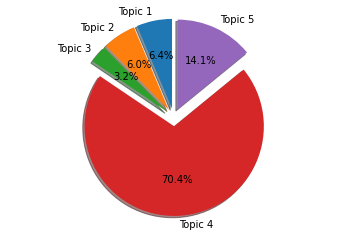

In [ ]:
labels = lambda_df.columns[1:]
sizes = prob_topics*100
explode = (0.1, 0.1, 0.1,0.1, 0.1) 

fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.

plt.show()

# Tarefa extra

Tentar reproduzir o Gráfico 2 do roteiro do Estudo de caso 1.2, onde se analisa os temas predominantes em cada laboratório.